In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

from dataflow import df_train, df_test, df_geography, df_product

In [2]:
print(torch.cuda.is_available())      # True nếu có GPU
print(torch.cuda.device_count())      # Số lượng GPU có thể sử dụng
print(torch.cuda.get_device_name(0))  # Tên của GPU

True
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
# Kết nối tự nhiên giữa các bảng
df_train = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')
df_test = df_test.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [4]:
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Lấy các cột cần thiết cho mô hình
df_model = df_train[['Date', 'Units', 'Revenue']]
df_test = df_test[['Date', 'Units', 'Revenue']]

# Nhóm theo ngày và tính tổng số lượng bán (Units) và doanh thu (Revenue) mỗi ngày
df_train = df_model.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()
df_test = df_test.groupby('Date').agg({'Units': 'sum', 'Revenue': 'sum'}).reset_index()

In [5]:
# Tạo dãy ngày đầy đủ từ ngày nhỏ nhất đến ngày lớn nhất trong dữ liệu
full_date_range = pd.date_range(start=df_train['Date'].min(), end=df_train['Date'].max(), freq='D')

# Đặt cột Date làm index để dễ thao tác
df_train.set_index('Date', inplace=True)

# Reindex DataFrame với dãy ngày đầy đủ. Các ngày thiếu sẽ có giá trị NaN
df_train = df_train.reindex(full_date_range)
df_train.index.name = 'Date'

# Sử dụng nội suy tuyến tính dựa trên thời gian để điền các giá trị thiếu
df_train['Units'] = df_train['Units'].interpolate(method='time')
df_train['Revenue'] = df_train['Revenue'].interpolate(method='time')

# Trong trường hợp giá trị tại đầu hoặc cuối chuỗi vẫn là NaN, sử dụng forward/backward fill
df_train['Units'] = df_train['Units'].ffill().bfill()
df_train['Revenue'] = df_train['Revenue'].ffill().bfill()

# Reset index để đưa Date trở lại làm cột thông thường
df_train = df_train.reset_index()

In [6]:
def add_time_features(df):
    """
    Thêm các đặc trưng thời gian, sử dụng cyclical encoding cho day_of_week và month.
    Giả định df có cột Date dạng datetime.
    """
    df['day_of_week'] = df['Date'].dt.dayofweek  # 0: Thứ Hai, 6: Chủ Nhật
    df['month'] = df['Date'].dt.month             # 1 đến 12

    # Cyclical encoding cho day_of_week
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    # Cyclical encoding cho month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Các cờ khác
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_holiday'] = df['Date'].isin(holidays).astype(int)
    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    
    return df

In [7]:
df_train = add_time_features(df_train)
df_test = add_time_features(df_test)

In [8]:
scaler = StandardScaler()
df_train[['Units', 'Revenue']] = scaler.fit_transform(df_train[['Units', 'Revenue']])
df_test[['Units', 'Revenue']] = scaler.transform(df_test[['Units', 'Revenue']])

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size=30):
        """
        Mỗi mẫu gồm:
         - x_seq: chuỗi lịch sử (window_size ngày) với 2 biến liên tục đã chuẩn hóa: Units và Revenue.
         - x_cal: các đặc trưng lịch của ngày dự báo, bao gồm các cột ngoài ['Date', 'Units', 'Revenue'].
         - y: giá trị dự báo của ngày đó (Units, Revenue).
        """
        self.window_size = window_size
        self.df = df.sort_values('Date').reset_index(drop=True)
        # Các cột đặc trưng lịch là tất cả các cột ngoại trừ Date, Units, Revenue
        self.calendar_feature_cols = [col for col in self.df.columns if col not in ['Date', 'Units', 'Revenue']]
        self.seq_cols = ['Units', 'Revenue']
        
    def __len__(self):
        return len(self.df) - self.window_size
    
    def __getitem__(self, idx):
        x_seq = self.df.loc[idx:idx+self.window_size-1, self.seq_cols].values.astype(np.float32)
        x_cal = self.df.loc[idx+self.window_size, self.calendar_feature_cols].values.astype(np.float32)
        y = self.df.loc[idx+self.window_size, ['Units', 'Revenue']].values.astype(np.float32)
        return x_seq, x_cal, y

In [10]:
window_size = 30
batch_size = 64

# Tạo dataset và DataLoader cho train (với validation tách ngẫu nhiên) và test
full_dataset = TimeSeriesDataset(df_train, window_size=window_size)
test_dataset = TimeSeriesDataset(df_test, window_size=window_size)

# Tách tập train và validation (20% validation)
seed = 42
torch.manual_seed(seed)
dataset_length = len(full_dataset)
val_size = int(0.2 * dataset_length)
train_size = dataset_length - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [12]:
class ImprovedTemporalFusionTransformer(nn.Module):
    def __init__(self, seq_input_dim, cal_input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1):
        """
        Phiên bản cải tiến:
          - Dự án đầu vào chuỗi qua một lớp Linear và Positional Encoding, 
            sau đó xử lý bằng TransformerEncoder (batch_first=True).
          - Xử lý đặc trưng ngoại lai (static) qua một mạng FC.
          - Cơ chế gating: từ vector tóm tắt của chuỗi và vector static, tính gate để kết hợp hai nguồn thông tin.
          - Sử dụng kết nối dư (residual connection) sau fusion.
          - Đầu ra dự báo qua một tầng FC cuối cùng.
        """
        super(ImprovedTemporalFusionTransformer, self).__init__()
        # Xử lý chuỗi thời gian
        self.input_projection = nn.Linear(seq_input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Xử lý đặc trưng static (calendar)
        self.static_fc = nn.Sequential(
            nn.Linear(cal_input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Cơ chế gating: kết hợp thông tin chuỗi và static
        self.gate_fc = nn.Sequential(
            nn.Linear(2 * d_model, d_model),
            nn.Sigmoid()
        )
        
        # Lớp hợp nhất với residual connection
        self.fc_fusion = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Lớp đầu ra
        self.output_layer = nn.Linear(d_model, output_dim)
    
    def forward(self, x_seq, x_cal):
        # Xử lý chuỗi thời gian
        # x_seq: (batch, seq_len, seq_input_dim)
        temporal = self.input_projection(x_seq)     # (batch, seq_len, d_model)
        temporal = self.positional_encoding(temporal) # (batch, seq_len, d_model)
        temporal = self.transformer_encoder(temporal) # (batch, seq_len, d_model)
        temporal_feature = temporal[:, -1, :]         # (batch, d_model)
        
        # Xử lý đặc trưng static
        static_feature = self.static_fc(x_cal)        # (batch, d_model)
        
        # Kết hợp qua cơ chế gating
        combined = torch.cat([temporal_feature, static_feature], dim=1)  # (batch, 2*d_model)
        gate = self.gate_fc(combined)                   # (batch, d_model), giá trị trong [0,1]
        fused = gate * temporal_feature + (1 - gate) * static_feature  # (batch, d_model)
        
        # Hợp nhất cuối cùng với residual connection
        fused_out = self.fc_fusion(fused) + fused  # (batch, d_model)
        output = self.output_layer(fused_out)       # (batch, output_dim)
        return output

In [13]:
# Xác định kích thước input cho mô hình
seq_input_dim = 2  # "Units" và "Revenue" (chuỗi lịch sử)
cal_feature_cols = [col for col in df_train.columns if col not in ['Date', 'Units', 'Revenue']]
cal_input_dim = len(cal_feature_cols)

# Cấu hình mô hình TFT
d_model = 64
nhead = 4
num_layers = 2
output_dim = 2  # Dự báo Units và Revenue

In [14]:
model = ImprovedTemporalFusionTransformer(seq_input_dim, cal_input_dim, d_model, nhead, num_layers, output_dim, dropout=0.1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [15]:
# Cấu hình optimizer, loss, scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

num_epochs = 100  # Bạn có thể tăng số epoch nếu cần
best_val_loss = float('inf')
train_losses = []
val_losses = []

In [16]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        outputs = model(x_seq, x_cal)
        loss = criterion(outputs, y)
        loss.backward()
        
        # Áp dụng gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            outputs = model(x_seq, x_cal)
            loss = criterion(outputs, y)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'models/TFT.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 0.8002
Best model updated at epoch 2 with validation loss 0.7393
Best model updated at epoch 3 with validation loss 0.6667
Best model updated at epoch 4 with validation loss 0.6080
Best model updated at epoch 6 with validation loss 0.5895
Epoch [10/100], Train Loss: 0.5046, Val Loss: 0.5584
Best model updated at epoch 10 with validation loss 0.5584
Best model updated at epoch 11 with validation loss 0.5117
Best model updated at epoch 12 with validation loss 0.5080
Best model updated at epoch 15 with validation loss 0.4723
Epoch [20/100], Train Loss: 0.3562, Val Loss: 0.4820
Best model updated at epoch 24 with validation loss 0.4651
Best model updated at epoch 29 with validation loss 0.4650
Epoch [30/100], Train Loss: 0.3013, Val Loss: 0.4871
Best model updated at epoch 33 with validation loss 0.4564
Best model updated at epoch 36 with validation loss 0.4537
Best model updated at epoch 39 with validation loss 0.4223
Epoch [40/100], Trai

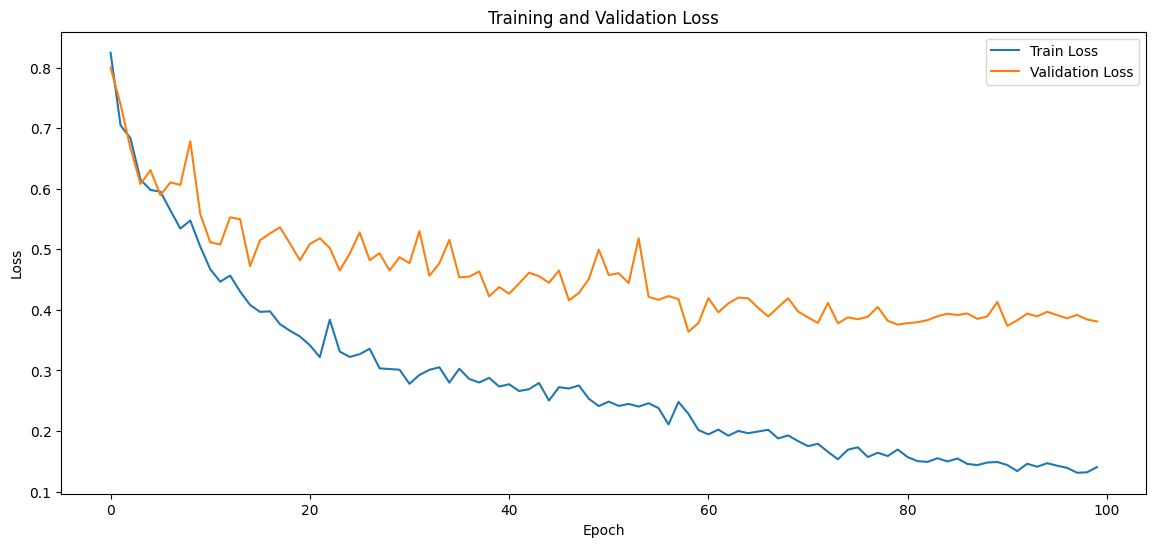

In [17]:
# Vẽ đồ thị loss
plt.figure(figsize=(14, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [18]:
# Load lại mô hình tốt nhất
checkpoint = torch.load('models/TFT.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Best model loaded with validation loss: {checkpoint['val_loss']:.4f}")

Best model loaded with validation loss: 0.3640


In [19]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            outputs = model(x_seq, x_cal)
            preds.append(outputs.cpu().numpy())
            actuals.append(y.numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

In [20]:
# Dự báo trên tập train và test
train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

# Tính các chỉ số đánh giá trên tập test
r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.6122
Test MAPE: 0.7425
Test RMSE: 452670.8438


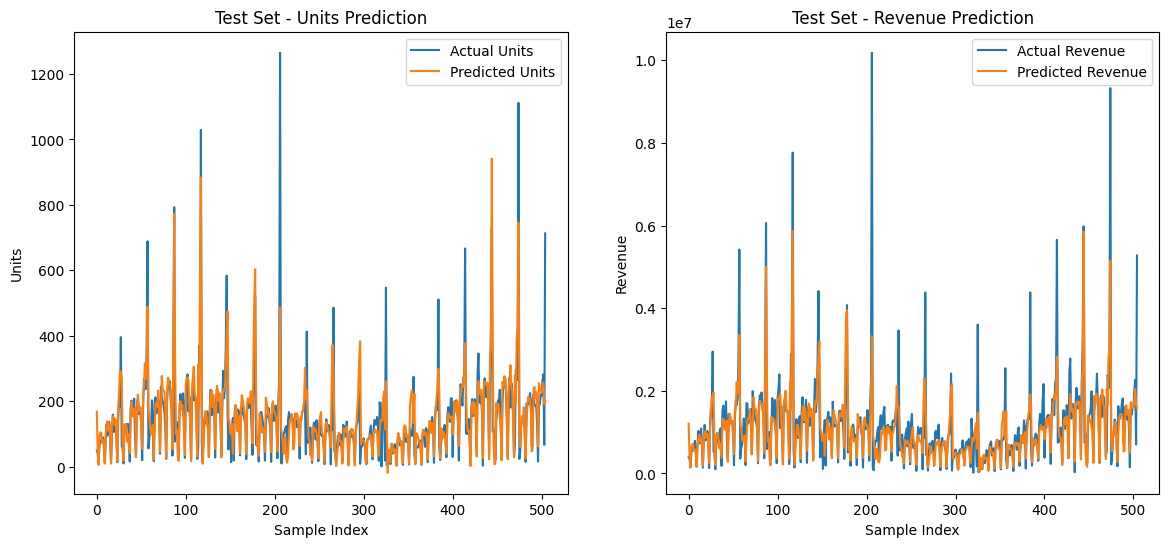

In [21]:
# Vẽ đồ thị dự báo cho Units và Revenue trên tập test
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(test_actuals_inv[:, 0], label='Actual Units')
plt.plot(test_preds_inv[:, 0], label='Predicted Units')
plt.xlabel("Sample Index")
plt.ylabel("Units")
plt.title("Test Set - Units Prediction")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_actuals_inv[:, 1], label='Actual Revenue')
plt.plot(test_preds_inv[:, 1], label='Predicted Revenue')
plt.xlabel("Sample Index")
plt.ylabel("Revenue")
plt.title("Test Set - Revenue Prediction")
plt.legend()
plt.show()